In [1]:
chosen_file='None'

# Music Genre Identifier

In [2]:

import librosa
import librosa.display
from librosa.feature import rms, chroma_stft, spectral_bandwidth, zero_crossing_rate, spectral_contrast, mfcc
import sox
from pydub import AudioSegment

import pandas as pd
import os
import shutil
import numpy as np
from nltk import FreqDist

from keras.models import load_model
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler

import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from PIL import Image
import IPython.display as ipd
from IPython.display import Markdown as md

import joblib
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

%matplotlib inline


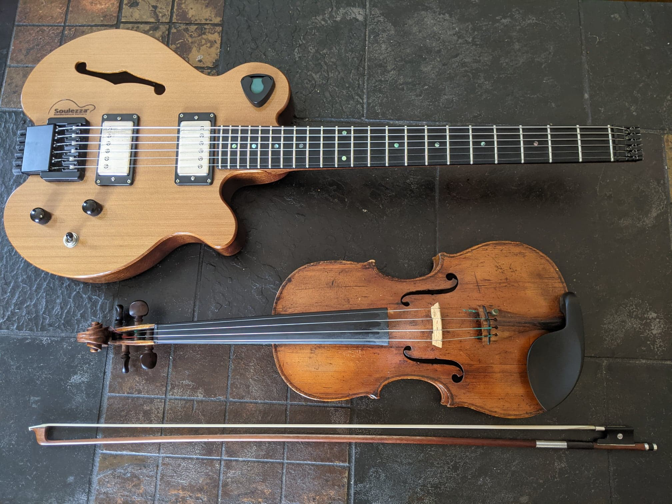

In [3]:
processed_path = '../../data_music/classify/'
    
if chosen_file == 'None':
    image='../../pictures/classify_cover.jpg'

    image=Image.open(image)
    width, height = image.size
    new_width=int(width/3)
    new_height=int(height/3)
    display(image.resize((new_width, new_height)))
else:
    for f in os.listdir(processed_path):
        os.remove(os.path.join(processed_path, f))
    shutil.copy(chosen_file, processed_path)

    

In [4]:
### Loading models

In [6]:
## %run setup_recommendation_df.py
base_dir = '../../data_music/'

dirpath = base_dir + 'recomm_db/'
recomm_df = pd.read_csv('../../features/recomm_processed_feat_new.csv')

skip=35

In [9]:
model = load_model('../../models/NN_best_model_6sec_14genres_new.h5')
modelCNN = load_model('../../models/CNN_best_model_5sec(94).h5')


with open('../../models/XGB_gs_pipe_new.joblib', 'rb') as f:
    model2 = joblib.load(f)
    
    
with open('../../models/NN_transformers_6sec_14genres_new.joblib', 'rb') as f:
    encoder,scaler = joblib.load(f)
    
genres=encoder.classes_

In [10]:
def generate_image(x, image_chunk_name):
    fig, ax = plt.subplots(figsize=(2,2))

    x_stft = librosa.stft(x)
    ampl = librosa.amplitude_to_db(abs(x_stft))
    p=librosa.display.specshow(ampl, sr=20500, hop_length=512, x_axis='time',  y_axis='log',  ax=ax, cmap='inferno')

    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    plt.style.use('ggplot')

    fig.tight_layout(pad=0)
    fig.savefig(image_chunk_name)
    fig.clear()
    plt.close(fig)


In [11]:
def extract_wave_features (x, sr):
    feat_dic={}
    x_harm, x_perc = librosa.effects.hpss(x)

# Power Based total Means
    for num, series in enumerate([ x_harm, x_perc]):
        label={0:'harm',1:'perc'}
        for func in [rms, chroma_stft, spectral_bandwidth, zero_crossing_rate]:
            feat_name=str(func).split()[1]
            if func == rms:
                s=librosa.stft(series)
                S, phase = librosa.magphase(s)
                feature = np.mean(func(S=S))
            else:
                feature = np.mean(func(y=series))
            feat_dic[f'{feat_name}_{label[num]}_mean']=feature

# Power Based Multiple Means
    for func in [ mfcc]:
        feat_lst = np.mean(func(y=x, sr=sr, n_mfcc=13), axis=1)

        feat_name=str(func).split()[1]

        for num, feature in enumerate(feat_lst):
            feat_dic[f'{feat_name}_{num}']=feature
# Energy Based:
    for func in [spectral_contrast ]:
        s=librosa.stft(x)
        feat_lst = np.mean(func(S=np.abs(s), sr=sr), axis=1)
        feat_name=str(func).split()[1]
        for num, feature in enumerate(feat_lst):
            feat_dic[f'{feat_name}_{num}']=feature
# Tempo    
    tempo, beat_frames = librosa.beat.beat_track(y=x_harm, sr=sr)
    feat_dic['Tempo']=tempo
    
    return feat_dic

In [12]:

def extract_file_features(mp3_path, mini_chunk_length, mini_chunk_n):
    feat_data_lst=[]
    spectrogram_lst=[]
    
    song_file=mp3_path.split('.mp3')[0] +'.wav'
    chunk_base = mp3_path.split('.mp3')[0]
 
    sound = AudioSegment.from_mp3(mp3_path)
    sound.export(song_file, format="wav")
    song_duration=sox.file_info.duration(song_file)-skip

    if mini_chunk_length > song_duration: 
        mini_chunk_length = int(song_duration)

    sample_duration=mini_chunk_length*mini_chunk_n

    if sample_duration > song_duration:
        sample_duration = song_duration
        mini_chunk_n=int(song_duration//mini_chunk_length)

    y, sr = librosa.load(song_file, offset=skip, duration=sample_duration)
    os.remove(song_file)
    mini_chunk_samples = mini_chunk_length * sr

    for mini_chunk in range(mini_chunk_n):
        start = mini_chunk * mini_chunk_samples
        end = start + mini_chunk_samples
        ch = y[start:end]
        
        image_chunk_name=chunk_base +'-' + str(mini_chunk) + '.png'
        generate_image(ch, image_chunk_name)
        image = np.asarray(load_img(image_chunk_name, color_mode='rgba', target_size=(100,100)))/255
        os.remove(image_chunk_name)
        
#        print(image[0])
        spectrogram_lst.append(image)
        
        feat_dic=extract_wave_features(ch, sr)
        feat_data_lst.append(feat_dic)
    return feat_data_lst, np.array(spectrogram_lst)

In [13]:
def extract_featues(processed_path, mini_chunk_length, mini_chunk_n):
    feat_all_lst=[]
#    spectrogram_all_lst=[]
        
    if chosen_file == 'None':
        song_files=[x for x in os.listdir(processed_path) if x.endswith('.mp3')]
    else:
        song_files=[chosen_file]

    for mp3 in song_files:
        print(mp3) 
        
        mp3_path=processed_path + mp3

        ipd.display(ipd.Audio(mp3_path))
        feat_lst, spectrogram_lst = extract_file_features(mp3_path, mini_chunk_length, mini_chunk_n) 
        feat_all_lst.extend(feat_lst)
#        spectrogram_all_lst.extend(spectrogram_lst)
    
    classify_df=pd.DataFrame.from_dict(feat_all_lst)
    classify_df.columns=feat_all_lst[0].keys()
    return mini_chunk_length, classify_df, spectrogram_lst


In [14]:
def visualize (NN_pred, XGB_pred, CNN_pred, mini_chunk_n, mini_chunk_length, sum_prob, genre_dic, prediction_label):
    fig, ax = plt.subplots(figsize=(10,24), nrows=4)
    fontsize=30
    
    sns.scatterplot(x=(np.arange(mini_chunk_n)*mini_chunk_length)+skip, y=CNN_pred-0.1, 
                    alpha=0.4, s=350, color='red', label='CNN', ax=ax[2], marker='s')

    sns.scatterplot(x=(np.arange(mini_chunk_n)*mini_chunk_length)+skip, y=NN_pred-0.1, 
                    alpha=0.4, s=350, color='blue', label='NN', ax=ax[2])
    sns.scatterplot(x=(np.arange(mini_chunk_n)*mini_chunk_length)+skip, y=XGB_pred-0.1,
                    alpha=0.4,  s=350, color='green', label='XGB', ax=ax[2], marker ='^')

    sns.barplot(x=genres, y=sum_prob, color='green', ax=ax[3]);
    
    wc = WordCloud(background_color="black",  collocations=False,  max_font_size=2000, min_font_size=1, 
           width=1600, height=800, relative_scaling=1 ).generate_from_frequencies(genre_dic)
    ax[1].set_title('Genre Traits:', fontsize=fontsize, loc='left')
    ax[1].imshow(wc, interpolation='bilinear')
    ax[1].axis("off");
    
    ax[0].set_title('Primary Genre:',fontsize=fontsize, loc='left')
    wc = WordCloud(background_color="white",  collocations=False,  max_font_size=2000, min_font_size=1, 
       width=1600, height=800, relative_scaling=1 ).generate_from_text(prediction_label)
    ax[0].imshow(wc, interpolation='bilinear')
    ax[0].axis("off");
    
    ax[3].set_title('Genre Probabilities:', fontsize=fontsize, loc='left')
    ax[3].set_xticklabels(ax[3].get_xticklabels(),rotation = 75, size=20)
    ax[3].set_yticklabels([round(tick,2) for tick in ax[3].get_yticks()], size=15)

    ax[2].set_title('Genre Influences Analysis:',fontsize=fontsize, loc='left')
    ax[2].set_yticklabels(genres, size=15)
    ax[2].set_yticks(range(len(genres)))
    ax[2].set_xlabel('Seconds');
    ax[2].legend()
    ax[2].set_ylim(-1, len(genres)+1);

    plt.style.use('ggplot')

    fig.tight_layout(pad=0)

    

In [15]:
def print_details (XGB_prob, NN_prob, CNN_prob, XGB_pred, NN_pred, CNN_pred, sum_prob, prediction, prediction_label):
    print('======================================================')
    print('XGB: ', XGB_pred)
    print('NN: ', NN_pred)
    print('CNN: ', CNN_pred)

    print('--------------------------------------------')
    print('XGB prob: ', sum(XGB_prob),': ', np.argmax(sum(XGB_prob)))
    print('NN prob: ',sum(NN_prob),': ', np.argmax(sum(NN_prob) )) 
    print('CNN prob: ',sum(CNN_prob),': ', np.argmax(sum(CNN_prob) )) 

    print('--------------------------------------------')
    print(sum_prob)
    print(prediction_label, ': ', prediction)
    print('======================================================')

In [16]:
def classify (model, model2, modelCNN, processed_path, mini_chunk_length, mini_chunk_n ):
    np.set_printoptions(suppress=True)

    mini_chunk_length, classify_df, spectrogram_all_lst =extract_featues(processed_path, mini_chunk_length, mini_chunk_n)
    mini_chunk_n=np.shape(classify_df)[0]
    
    X=classify_df.drop('Tempo', axis=1)
    X_scaled = scaler.transform(np.array(X, dtype = float))
    
    CNN_prob = modelCNN.predict(spectrogram_all_lst)
    NN_prob=model.predict(X_scaled)
    XGB_prob=model2.predict_proba(X)

    CNN_pred=np.argmax(CNN_prob, axis=1)
    NN_pred=np.argmax(NN_prob, axis=1)
    XGB_pred=model2.predict(X)

    joined=np.concatenate((CNN_pred,NN_pred,XGB_pred),axis=0)

    sum_prob=sum(XGB_prob)+sum(NN_prob)+sum(CNN_prob)
    sum_prob=sum_prob/np.sum(sum_prob)

    prediction=np.argmax(sum(XGB_prob)+sum(NN_prob)+sum(CNN_prob))
    prediction_label=encoder.inverse_transform([prediction])[0]
    
    genre_vote_freqdist=FreqDist([encoder.inverse_transform([x])[0] for x in joined])

    genre_dic={}
    for key,value in  genre_vote_freqdist.most_common(3):
        genre_dic[key]=value
    
    visualize (NN_pred, XGB_pred, CNN_pred, mini_chunk_n, mini_chunk_length, sum_prob, genre_dic, prediction_label)
    print_details (XGB_prob, NN_prob, CNN_prob, XGB_pred, NN_pred, CNN_pred, sum_prob, prediction, prediction_label)
    
    return prediction_label, classify_df
 #   return NN_pred, XGB_pred, CNN_pred, mini_chunk_n, mini_chunk_length, sum_prob, genre_dic, prediction_label, classify_df


In [17]:
def display_recommendations(prediction, classify_df, recomm_df, num):
#    features=['rms_harm_mean','rms_perc_mean', 'spectral_contrast_0',
#              'spectral_contrast_5','mfcc_2', 'mfcc_3', 'mfcc_4', 'Tempo' ]
    features=[  'Tempo', 'spectral_contrast_0', 'rms_harm_mean' ]
  
    
    if sum(recomm_df['Genre']==prediction) == 0:
        print('Cannot Find a genre!')
        return None
    database_genre=recomm_df[recomm_df['Genre']==prediction].copy()
    #database_genre=recomm_df.copy()
    database_feat=database_genre[features].reset_index(drop=True)
    
    given_feat=list(classify_df[features].mean())
    database_feat.loc[len(database_feat)] = given_feat
    
    database_feat_scaled=(database_feat-np.mean(database_feat))/np.std(database_feat)
    given_feat_scaled=database_feat_scaled.iloc[len(database_feat)-1]
    
    score_list=[]
    for row in np.array(database_feat_scaled):
        score=mean_squared_error(row, given_feat_scaled, squared=False)
        if score != 0:
            score_list.append(score)
        
    database_genre['Score']=score_list
    recommendations=database_genre.sort_values(by='Score').head(6)
    recommendations=recommendations.sample(num).sort_values(by='Score')

    for file in recommendations['Filename']:
        filepath=dirpath+file
        print(file)
        ipd.display(ipd.Audio(filepath))
    
    return database_genre.sort_values(by='Score')[['Score','Filename']].head(20)

In [ ]:
def get_genre (processed_path):
    prediction, classify_df = classify(model, model2, modelCNN, processed_path, 5, 13)
    return prediction, classify_df



In [ ]:
md(f"## Identifying genre:")

In [ ]:
prediction, classify_df = get_genre(processed_path)


In [ ]:
md(f"## Getting recommendations:") 

In [ ]:

result_df=display_recommendations(prediction, classify_df, recomm_df, 3)